In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import spacy
from spacy.tokens import Doc
from spacy.vocab import Vocab
from spacy.matcher import Matcher

import re

In [5]:
cdu_data = pd.read_json('cdu-tweets.json', lines=True)

# Data Cleaning

In [6]:
cdu_data.head()

,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers
0,https://twitter.com/CDU/status/136969882115284...,2021-03-10 17:17:01+00:00,⏩ Es muss ein Klick durch #RLP gehen! RLP hat ...,⏩ Es muss ein Klick durch #RLP gehen! RLP hat ...,1369698821152849924,"{'username': 'CDU', 'displayname': 'CDU Deutsc...",[],[],35,11,...,2,1369698821152849924,de,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,[{'previewUrl': 'https://pbs.twimg.com/media/E...,NaN,None,None
1,https://twitter.com/CDU/status/136963814492098...,2021-03-10 13:15:55+00:00,"Mehr Tempo bei der Digitalisierung, Datenschut...","Mehr Tempo bei der Digitalisierung, Datenschut...",1369638144920989699,"{'username': 'CDU', 'displayname': 'CDU Deutsc...",[https://www.cdu.de/aktuelles/laschet-will-meh...,[https://t.co/DsxUKH1D9q],138,12,...,32,1369638144920989699,de,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,[{'previewUrl': 'https://pbs.twimg.com/media/E...,NaN,None,"[{'username': 'ArminLaschet', 'displayname': '..."
2,https://twitter.com/CDU/status/136962605861879...,2021-03-10 12:27:53+00:00,Die beiden tollen Kandidatinnen sind übrigens ...,Die beiden tollen Kandidatinnen sind übrigens ...,1369626058618793985,"{'username': 'CDU', 'displayname': 'CDU Deutsc...",[],[],8,2,...,1,1369607239925981195,de,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,[{'previewUrl': 'https://pbs.twimg.com/media/E...,NaN,None,"[{'username': 'nicolerazavi', 'displayname': '..."
3,https://twitter.com/CDU/status/136960723992598...,2021-03-10 11:13:06+00:00,.@ArminLaschet bei der CDU Göppingen zur Unter...,.@ArminLaschet bei der CDU Göppingen zur Unter...,1369607239925981195,"{'username': 'CDU', 'displayname': 'CDU Deutsc...",[],[],39,6,...,4,1369607239925981195,de,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,[{'previewUrl': 'https://pbs.twimg.com/media/E...,NaN,None,"[{'username': 'ArminLaschet', 'displayname': '..."
4,https://twitter.com/CDU/status/136953750332617...,2021-03-10 06:36:00+00:00,Damit der Südwesten international dauerhaft we...,Damit der Südwesten international dauerhaft we...,1369537503326179329,"{'username': 'CDU', 'displayname': 'CDU Deutsc...",[https://bwwahl2021.de/wirtschaft/],[https://t.co/PqbAdtZYQP],86,17,...,4,1369537503326179329,de,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,[{'previewUrl': 'https://pbs.twimg.com/media/E...,NaN,None,"[{'username': 'CDU_BW', 'displayname': 'CDU Ba..."


In [7]:
#List all columns 
cdu_data.columns

Index(['url', 'date', 'content', 'renderedContent', 'id', 'user', 'outlinks',
       'tcooutlinks', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel', 'media',
       'retweetedTweet', 'quotedTweet', 'mentionedUsers'],
      dtype='object')

In [8]:
#Drop above rows
cdu_data = cdu_data.drop(["url","id","renderedContent","conversationId","lang","source","sourceLabel","media"],axis=1)

In [9]:
#Check new columns
cdu_data.columns

Index(['date', 'content', 'user', 'outlinks', 'tcooutlinks', 'replyCount',
       'retweetCount', 'likeCount', 'quoteCount', 'sourceUrl',
       'retweetedTweet', 'quotedTweet', 'mentionedUsers'],
      dtype='object')

In [10]:
cdu_data.head()

,date,content,user,outlinks,tcooutlinks,replyCount,retweetCount,likeCount,quoteCount,sourceUrl,retweetedTweet,quotedTweet,mentionedUsers
0,2021-03-10 17:17:01+00:00,⏩ Es muss ein Klick durch #RLP gehen! RLP hat ...,"{'username': 'CDU', 'displayname': 'CDU Deutsc...",[],[],35,11,39,2,https://mobile.twitter.com,NaN,None,None
1,2021-03-10 13:15:55+00:00,"Mehr Tempo bei der Digitalisierung, Datenschut...","{'username': 'CDU', 'displayname': 'CDU Deutsc...",[https://www.cdu.de/aktuelles/laschet-will-meh...,[https://t.co/DsxUKH1D9q],138,12,73,32,https://mobile.twitter.com,NaN,None,"[{'username': 'ArminLaschet', 'displayname': '..."
2,2021-03-10 12:27:53+00:00,Die beiden tollen Kandidatinnen sind übrigens ...,"{'username': 'CDU', 'displayname': 'CDU Deutsc...",[],[],8,2,21,1,https://mobile.twitter.com,NaN,None,"[{'username': 'nicolerazavi', 'displayname': '..."
3,2021-03-10 11:13:06+00:00,.@ArminLaschet bei der CDU Göppingen zur Unter...,"{'username': 'CDU', 'displayname': 'CDU Deutsc...",[],[],39,6,40,4,http://twitter.com/download/iphone,NaN,None,"[{'username': 'ArminLaschet', 'displayname': '..."
4,2021-03-10 06:36:00+00:00,Damit der Südwesten international dauerhaft we...,"{'username': 'CDU', 'displayname': 'CDU Deutsc...",[https://bwwahl2021.de/wirtschaft/],[https://t.co/PqbAdtZYQP],86,17,65,4,https://mobile.twitter.com,NaN,None,"[{'username': 'CDU_BW', 'displayname': 'CDU Ba..."


In [11]:
cdu_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17100 entries, 0 to 17099
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   date            17100 non-null  datetime64[ns, UTC]
 1   content         17100 non-null  object             
 2   user            17100 non-null  object             
 3   outlinks        17100 non-null  object             
 4   tcooutlinks     17100 non-null  object             
 5   replyCount      17100 non-null  int64              
 6   retweetCount    17100 non-null  int64              
 7   likeCount       17100 non-null  int64              
 8   quoteCount      17100 non-null  int64              
 9   sourceUrl       17100 non-null  object             
 10  retweetedTweet  0 non-null      float64            
 11  quotedTweet     1900 non-null   object             
 12  mentionedUsers  8290 non-null   object             
dtypes: datetime64[ns, UTC](1), floa

In [12]:
#Check percentage of data with NaN values: We can also remove retweetedTweet, quoted Tweet

cdu_data.isna().sum() * 100 / len(cdu_data)

date                0.000000
content             0.000000
user                0.000000
outlinks            0.000000
tcooutlinks         0.000000
replyCount          0.000000
retweetCount        0.000000
likeCount           0.000000
quoteCount          0.000000
sourceUrl           0.000000
retweetedTweet    100.000000
quotedTweet        88.888889
mentionedUsers     51.520468
dtype: float64

In [13]:
cdu_data = cdu_data.drop(['retweetedTweet','quotedTweet'],axis=1)

In [14]:
cdu_data.columns

Index(['date', 'content', 'user', 'outlinks', 'tcooutlinks', 'replyCount',
       'retweetCount', 'likeCount', 'quoteCount', 'sourceUrl',
       'mentionedUsers'],
      dtype='object')

In [15]:
cdu_data.dtypes

date              datetime64[ns, UTC]
content                        object
user                           object
outlinks                       object
tcooutlinks                    object
replyCount                      int64
retweetCount                    int64
likeCount                       int64
quoteCount                      int64
sourceUrl                      object
mentionedUsers                 object
dtype: object

In [16]:
cdu_data.head()

,date,content,user,outlinks,tcooutlinks,replyCount,retweetCount,likeCount,quoteCount,sourceUrl,mentionedUsers
0,2021-03-10 17:17:01+00:00,⏩ Es muss ein Klick durch #RLP gehen! RLP hat ...,"{'username': 'CDU', 'displayname': 'CDU Deutsc...",[],[],35,11,39,2,https://mobile.twitter.com,None
1,2021-03-10 13:15:55+00:00,"Mehr Tempo bei der Digitalisierung, Datenschut...","{'username': 'CDU', 'displayname': 'CDU Deutsc...",[https://www.cdu.de/aktuelles/laschet-will-meh...,[https://t.co/DsxUKH1D9q],138,12,73,32,https://mobile.twitter.com,"[{'username': 'ArminLaschet', 'displayname': '..."
2,2021-03-10 12:27:53+00:00,Die beiden tollen Kandidatinnen sind übrigens ...,"{'username': 'CDU', 'displayname': 'CDU Deutsc...",[],[],8,2,21,1,https://mobile.twitter.com,"[{'username': 'nicolerazavi', 'displayname': '..."
3,2021-03-10 11:13:06+00:00,.@ArminLaschet bei der CDU Göppingen zur Unter...,"{'username': 'CDU', 'displayname': 'CDU Deutsc...",[],[],39,6,40,4,http://twitter.com/download/iphone,"[{'username': 'ArminLaschet', 'displayname': '..."
4,2021-03-10 06:36:00+00:00,Damit der Südwesten international dauerhaft we...,"{'username': 'CDU', 'displayname': 'CDU Deutsc...",[https://bwwahl2021.de/wirtschaft/],[https://t.co/PqbAdtZYQP],86,17,65,4,https://mobile.twitter.com,"[{'username': 'CDU_BW', 'displayname': 'CDU Ba..."


In [17]:
#Date column is not a good represenation, we add year, month, day separately
cdu_data['year'] = pd.DatetimeIndex(cdu_data['date']).year
cdu_data['month'] = pd.DatetimeIndex(cdu_data['date']).month
cdu_data['day'] = pd.DatetimeIndex(cdu_data['date']).day

In [18]:
cdu_data = cdu_data.drop(['date'],axis=1)

In [19]:
#Checking the 'user' column, we have a lot of data about the author of the tweet
#we might not need. Maybe delete this column too?
print(cdu_data['user'][0])

cdu_data = cdu_data.drop('user',axis=1)

{'username': 'CDU', 'displayname': 'CDU Deutschlands', 'id': 20429858, 'description': 'Die #CDU ist die Volkspartei der Mitte. Seit 1945. - Redaktion: cdu.de/redaktion Impressum: cdu.de/impressum', 'rawDescription': 'Die #CDU ist die Volkspartei der Mitte. Seit 1945. - Redaktion: https://t.co/5uW0YgzHvo Impressum: https://t.co/AoefcbGyX1', 'descriptionUrls': [{'text': 'cdu.de/redaktion', 'url': 'https://www.cdu.de/redaktion', 'tcourl': 'https://t.co/5uW0YgzHvo', 'indices': [64, 87]}, {'text': 'cdu.de/impressum', 'url': 'https://www.cdu.de/impressum', 'tcourl': 'https://t.co/AoefcbGyX1', 'indices': [99, 122]}], 'verified': True, 'created': '2009-02-09T11:43:27+00:00', 'followersCount': 346322, 'friendsCount': 1610, 'statusesCount': 25420, 'favouritesCount': 10766, 'listedCount': 2028, 'mediaCount': 6144, 'location': 'Berlin', 'protected': False, 'linkUrl': 'http://www.cdu.de', 'linkTcourl': 'https://t.co/GGABUUSnFy', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1359527560015

In [20]:
cdu_data.head()

,content,outlinks,tcooutlinks,replyCount,retweetCount,likeCount,quoteCount,sourceUrl,mentionedUsers,year,month,day
0,⏩ Es muss ein Klick durch #RLP gehen! RLP hat ...,[],[],35,11,39,2,https://mobile.twitter.com,None,2021,3,10
1,"Mehr Tempo bei der Digitalisierung, Datenschut...",[https://www.cdu.de/aktuelles/laschet-will-meh...,[https://t.co/DsxUKH1D9q],138,12,73,32,https://mobile.twitter.com,"[{'username': 'ArminLaschet', 'displayname': '...",2021,3,10
2,Die beiden tollen Kandidatinnen sind übrigens ...,[],[],8,2,21,1,https://mobile.twitter.com,"[{'username': 'nicolerazavi', 'displayname': '...",2021,3,10
3,.@ArminLaschet bei der CDU Göppingen zur Unter...,[],[],39,6,40,4,http://twitter.com/download/iphone,"[{'username': 'ArminLaschet', 'displayname': '...",2021,3,10
4,Damit der Südwesten international dauerhaft we...,[https://bwwahl2021.de/wirtschaft/],[https://t.co/PqbAdtZYQP],86,17,65,4,https://mobile.twitter.com,"[{'username': 'CDU_BW', 'displayname': 'CDU Ba...",2021,3,10


In [21]:
# We might want to get rid of the outlinks and tcoutlinks columns too, since they do not provide useful information
#The sourceUrl also provides no useful information for our analysis purposes
cdu_data = cdu_data.drop(['outlinks','tcooutlinks'],axis=1)

In [22]:
cdu_data = cdu_data.drop(['sourceUrl'],axis=1)

In [23]:
cdu_data.head()

,content,replyCount,retweetCount,likeCount,quoteCount,mentionedUsers,year,month,day
0,⏩ Es muss ein Klick durch #RLP gehen! RLP hat ...,35,11,39,2,None,2021,3,10
1,"Mehr Tempo bei der Digitalisierung, Datenschut...",138,12,73,32,"[{'username': 'ArminLaschet', 'displayname': '...",2021,3,10
2,Die beiden tollen Kandidatinnen sind übrigens ...,8,2,21,1,"[{'username': 'nicolerazavi', 'displayname': '...",2021,3,10
3,.@ArminLaschet bei der CDU Göppingen zur Unter...,39,6,40,4,"[{'username': 'ArminLaschet', 'displayname': '...",2021,3,10
4,Damit der Südwesten international dauerhaft we...,86,17,65,4,"[{'username': 'CDU_BW', 'displayname': 'CDU Ba...",2021,3,10


In [24]:
#Same with the mentioned Users. It has a lot of nested information but most values are "None"
cdu_data['mentionedUsers'][1]

cdu_data = cdu_data.drop('mentionedUsers',axis=1)

In [25]:
cdu_data.head()

,content,replyCount,retweetCount,likeCount,quoteCount,year,month,day
0,⏩ Es muss ein Klick durch #RLP gehen! RLP hat ...,35,11,39,2,2021,3,10
1,"Mehr Tempo bei der Digitalisierung, Datenschut...",138,12,73,32,2021,3,10
2,Die beiden tollen Kandidatinnen sind übrigens ...,8,2,21,1,2021,3,10
3,.@ArminLaschet bei der CDU Göppingen zur Unter...,39,6,40,4,2021,3,10
4,Damit der Südwesten international dauerhaft we...,86,17,65,4,2021,3,10


### We are left with the most relevant information so far.
### Conent: for NLP analysis, topic modeling, sentiment analysis etc
### Timestamps of tweets

### replyCount,retweetCount, likeCount might be indicative of 'popularity' of certain tweets, but this needs to be evaluated further

### Luckily, the scraper we used, snscraper, already provided us with a relatively clean datarame. Only things we had to change were the time columns, and delete irrelevant information

In [26]:
#Save the clean data to a new csv file.
clean_cdu = cdu_data.to_csv('clean_cdu_twitter.csv')

In [88]:
#Export the 'content' column to a .txt file for NLP later
clean_cdu = pd.read_csv('clean_cdu_twitter.csv')

In [89]:
clean_cdu.columns

Index(['Unnamed: 0', 'content', 'replyCount', 'retweetCount', 'likeCount',
       'quoteCount', 'year', 'month', 'day'],
      dtype='object')

In [29]:
clean_cdu.to_csv(r'C:\Users\user\Desktop\졸업논문\Data\cdu_content.txt',header=None,index=None,sep=' ',mode='a')

In [90]:
clean_cdu.reset_index(drop=True,inplace=True)

In [91]:
clean_cdu.drop(['Unnamed: 0'],inplace=True,axis=1)

In [92]:
clean_cdu.reset_index(drop=True,inplace=True)

In [93]:
clean_cdu = clean_cdu.set_index('year')

In [94]:
clean_cdu.head()

,content,replyCount,retweetCount,likeCount,quoteCount,month,day
year,,,,,,,
2021,⏩ Es muss ein Klick durch #RLP gehen! RLP hat ...,35,11,39,2,3,10
2021,"Mehr Tempo bei der Digitalisierung, Datenschut...",138,12,73,32,3,10
2021,Die beiden tollen Kandidatinnen sind übrigens ...,8,2,21,1,3,10
2021,.@ArminLaschet bei der CDU Göppingen zur Unter...,39,6,40,4,3,10
2021,Damit der Südwesten international dauerhaft we...,86,17,65,4,3,10


In [64]:
ref = clean_cdu['content'].str.contains('flüchtling',case=False)

print("Proportion of tweets:", np.sum(ref) / clean_cdu.shape[0])

Proportion of tweets: 0.007543859649122807


In [96]:
#Remove Links in Data
clean_cdu['content'] = clean_cdu['content'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

In [103]:
#Remove Emojis
clean_cdu = clean_cdu.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

In [104]:
clean_cdu.head()

,content,replyCount,retweetCount,likeCount,quoteCount,month,day
year,,,,,,,
2021,Es muss ein Klick durch #RLP gehen! RLP hat b...,35,11,39,2,3,10
2021,"Mehr Tempo bei der Digitalisierung, Datenschut...",138,12,73,32,3,10
2021,Die beiden tollen Kandidatinnen sind brigens S...,8,2,21,1,3,10
2021,.@ArminLaschet bei der CDU Gppingen zur Unters...,39,6,40,4,3,10
2021,Damit der Sdwesten international dauerhaft wet...,86,17,65,4,3,10


In [99]:
#only_content = clean_cdu['content']

In [100]:
#only_content.to_csv(r'C:\Users\user\Desktop\졸업논문\Data\cdu_content2.txt',header=None,index=None,sep=' ',mode='a')

In [106]:
#content_cdu.txt has numbers in front of it so we try to get rid of them, in order not to it manually...
#This seems to work
with open('cdu_content.txt',"w",encoding='utf8') as f:
    for text in clean_cdu['content'].tolist():
        f.write(text + '\n')

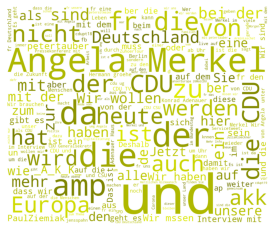

In [115]:
#https://stackoverflow.com/questions/42418085/python-wordcloud-from-a-txt-file
from wordcloud import WordCloud, STOPWORDS


def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 45.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

file_content=open ("cdu_content.txt").read()

wordcloud = WordCloud(
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            color_func = random_color_func
                            ).generate(file_content)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()